In [11]:
import os
import sys
import gym
import math
import random
import operator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torch.autograd as autograd 


# device 설정:GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ver7에서 Ver8 바꾼내용
* Noisy networks for exploration

In [12]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

# Replay Memory

In [13]:
class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        state = torch.tensor([state], device=device, dtype =torch.float)        
        reward = torch.tensor([reward], device=device, dtype = torch.float)
        next_state = torch.tensor([next_state], device=device, dtype =torch.float)
        done =  torch.tensor([done], device=device, dtype = torch.bool) 
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha > 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def push(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super(PrioritizedReplayBuffer, self).push(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

# Noisy Network

In [14]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

# NoisyNetwork

In [15]:
class NoisyDQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(NoisyDQN, self).__init__()
        
        self.linear =  nn.Linear(env.observation_space.shape[0], 128)
        self.noisy1 = NoisyLinear(128, 128)
        self.noisy2 = NoisyLinear(128, env.action_space.n)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        return x
    
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()

# Agent

In [16]:
class DQNAgent:
    def __init__(self, action_size):
        self.render = False

        self.action_size = action_size
        self.discount_factor = 0.99
        self.learning_rate = 0.001        
        self.train_start = 1000

        self.model = NoisyDQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model = NoisyDQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.optimizer = optim.Adam(
            self.model.parameters(), self.learning_rate)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def get_action(self, state):
        state = torch.tensor([state], device=device, dtype=torch.float)
        return self.model(state).detach().max(1)[1].view(1,1)  # tensor[[]]

    def train_model(self):        
        Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done', 'weights', 'indices'))        
        transitions = memory.sample(BATCH_SIZE, beta)
        batch = Transition(*zip(*transitions))  # batch에 BATCH_SIZE 만큼 state_batch, 등 5종류를 구분하여 꺼내둠       

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)
        weights_batch = torch.cat(batch.weights)
        indices_batch = torch.cat(batch.indices)

        predicts = self.model(state_batch).gather(1, action_batch)
        target_predicts = self.target_model(next_state_batch).detach()

        max_q = target_predicts.max(1)[0]
        targets = reward_batch + (~done_batch)*self.discount_factor*max_q

    # Huber Loss 계산
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicts, targets.unsqueeze(1))  # unsqueeze(): 차원 추가
        prios = loss + 1e-5
        loss = loss.mean()

    # Optimize parameters
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            # 모든 원소를 [ min, max ]의 범위로 clamp
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        memory.update_priorities(indices_batch, prios.detach().cpu().numpy())
        model.reset_noise()
        target_model.reset_noise()

# Main

In [17]:
env = gym.make('CartPole-v1')
action_size = env.action_space.n
beta_start = 0.4
beta_episodes = 10
beta_by_episode = lambda episode: min(1.0, beta_start + episode*(1.0 - beta_start)/beta_episodes)

# memory = ReplayMemory(2000)
memory = PrioritizedReplayBuffer(2000, alpha=0.6)

agent = DQNAgent(action_size)
scores, episodes = [], []
score_avg=0
HM_EPISODES = 300
BATCH_SIZE = 64

episode:   0 | score avg: 20.00 | steps: 20 | memory lengh:   20
episode:   1 | score avg: 19.50 | steps: 15 | memory lengh:   35
episode:   2 | score avg: 19.75 | steps: 22 | memory lengh:   57
episode:   3 | score avg: 19.98 | steps: 22 | memory lengh:   79
episode:   4 | score avg: 19.48 | steps: 15 | memory lengh:   94
episode:   5 | score avg: 19.13 | steps: 16 | memory lengh:  110
episode:   6 | score avg: 18.92 | steps: 17 | memory lengh:  127
episode:   7 | score avg: 19.53 | steps: 25 | memory lengh:  152
episode:   8 | score avg: 19.57 | steps: 20 | memory lengh:  172
episode:   9 | score avg: 19.42 | steps: 18 | memory lengh:  190
episode:  10 | score avg: 19.67 | steps: 22 | memory lengh:  212
episode:  11 | score avg: 19.61 | steps: 19 | memory lengh:  231
episode:  12 | score avg: 19.75 | steps: 21 | memory lengh:  252
episode:  13 | score avg: 20.17 | steps: 24 | memory lengh:  276
episode:  14 | score avg: 19.75 | steps: 16 | memory lengh:  292
episode:  15 | score avg:

TypeError: '>' not supported between instances of 'function' and 'int'

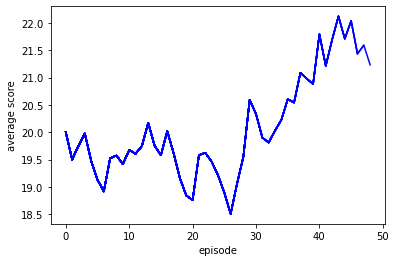

In [18]:
for episode in range(HM_EPISODES):    
    done = False
    score = 0
    steps = 0
    
    # env와 state 초기화
    state = env.reset()         

    while not done:    
        
        if agent.render:
            env.render()
        
        action = agent.get_action(state)    # action: tensor[[]]

        next_state, reward, done, info = env.step(action.item()) #next_state: np[], reward: [], done: []               
        score += reward
        reward = 0.1 if not done or score == 500 else -1        
        
        memory.push(state, action, next_state, reward, done) #state: np[], action: tensor[[]], reward: [], next_state: np[], done: []

                
        # (policy network에서) 최적화 한단계 수행                
        if len(memory) >= agent.train_start:
            beta = beta_by_episode
            agent.train_model()
            
 
        # 다음 상태로 이동
        state = next_state
        steps += 1

        # 마찬가지로 done이 True 라면,
        if done:
            agent.update_target_model()
            score_avg = 0.9 * score_avg + 0.1 * score if score_avg !=0 else score
            print('episode: {:3d} | score avg: {:3.2f} | steps:{:3d} | memory lengh: {:4d}'.format(
                episode, score_avg, steps, len(memory)))
            scores.append(score_avg)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('average score')
            
   
            if score_avg > 1000:
                sys.exit()       
    

    
print('Complete')
scores.clear
episodes.clear

